- [ ] select outlier based on distubtion (1.5*(Q3-Q1)) 
- [ ] scale numerical features
- [ ] Onehot encoding
- [ ] correlation test

Doctors have always written clinical notes about their patients - originally, the notes were on paper and were locked away in a cabinet. Fortunately for data scientists, doctors now enter their notes in an electronic medical record. These notes represent a vast wealth of knowledge and insight that can be utilized for predictive models using Natural Language Processing (NLP) to improve patient care and hospital workflow.

This notebook is intended for people interested in healthcare data science and predictive modeling and will help you learn
- How to prepare data for a machine learning project
- How to preprocess the unstructured notes
- How to build a simple predictive model using a bag-of-words approach
- How to assess the quality of your model
- How to decide the next step for improving the model

I recently read this great paper "Scalable and accurate deep learning for electronic health records" by Rajkomar et al. (paper at https://arxiv.org/abs/1801.07860). The authors built many state-of-the-art deep learning models with hospital data to predict in-hospital mortality (AUC = 0.93–0.94), 30-day unplanned readmission (AUC = 0.75–76), prolonged length of stay (AUC = 0.85–0.86) and discharge diagnoses (AUC = 0.90). AUC is a data science performance metric (more about this below) where closer to 1 is better. It is clear that predicting readmission is the hardest task since it has a lower AUC. I was curious how good of a model we can get if use the discharge free-text summaries with a simple predictive model.

# Model definition

Predict which patients are at risk for 30-day unplanned readmission utilizing free-text hospital discharge summaries.

# Data set

We will utilize the MIMIC-III (Medical Information Mart for Intensive Care III), an amazing free hospital database. This database contains de-identified data from over 40,000 patients who were admitted to Beth Israel Deaconess Medical Center in Boston, Massachusetts from 2001 to 2012. In order to get access to the data for this project, you will need to request access at this link (https://mimic.physionet.org/gettingstarted/access/).

In this project, we will make use of the following MIMIC tables
- ADMISSIONS - a table containing admission and discharge dates (has a unique identifier HADM_ID for each admission)
- NOTEEVENTS - contains all notes for each hospitalization (links with HADM_ID)

This notebook assumes that ADMISSIONS.csv and NOTEEVENTS.csv were downloaded and placed in the same folder as this notebook. 

Due to the restricted access, the github version of this code will not show any individual patient data. 

# Step 1. Prepare data

## Load admissions table

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = '../mimic-iii-clinical-database-1.4/'
df_adm = pd.read_csv(path + 'ADMISSIONS.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')

In [3]:
df_adm.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [4]:
df_adm.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA'],
      dtype='object')

In [5]:
df_adm.groupby(['ADMISSION_TYPE']).size()

ADMISSION_TYPE
ELECTIVE      7706
EMERGENCY    42071
NEWBORN       7863
URGENT        1336
dtype: int64

## Convert strings to dates

A note about dates from MIMIC website:
    
    All dates in the database have been shifted to protect patient confidentiality. Dates will be internally consistent for the same patient, but randomly distributed in the future.

When converting dates, it is safer to use a format. For references on formats see http://strftime.org/. Errors = 'coerce' allows NaT (not a datetime) to happen when the string doesn't match the format

In [6]:
# convert to dates
df_adm.ADMITTIME = pd.to_datetime(df_adm.ADMITTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_adm.DISCHTIME = pd.to_datetime(df_adm.DISCHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_adm.DEATHTIME = pd.to_datetime(df_adm.DEATHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

# check to see if there are any missing dates
print('Number of missing date admissions:', df_adm.ADMITTIME.isnull().sum())
print('Number of missing date discharges:', df_adm.DISCHTIME.isnull().sum())

Number of missing date admissions: 0
Number of missing date discharges: 0


In [7]:
df_adm.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


## Get the next admission date if it exists

**This step is really important because my original though is get the patients ID which is HADM_ID. And based ont the number of the records of the ID to know whether pathents have been readmitted. However, in this way, we can't know how many day there are between two readmissions. Also, a same patients can be readmitted several times and in different time spans. So, this is the best way to filter the readmissioned patients.**

In this project, we need the next admission date if it exists. We can get this with the shift() function, but we need to verify the dates are in order. 

In [8]:
# sort by subject_ID and admission date
df_adm = df_adm.sort_values(['SUBJECT_ID','ADMITTIME'])
df_adm = df_adm.reset_index(drop = True)

In [9]:
# verify that it did what we wanted, select SUBJECT_ID from EDA file
df_adm.loc[df_adm.SUBJECT_ID == 188,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE
244,188,2157-01-11 16:56:00,EMERGENCY
245,188,2157-03-07 11:08:00,EMERGENCY
246,188,2157-11-17 12:11:00,EMERGENCY
247,188,2160-11-25 21:55:00,EMERGENCY
248,188,2160-12-31 12:34:00,EMERGENCY
249,188,2161-07-01 19:44:00,EMERGENCY
250,188,2161-11-01 17:48:00,EMERGENCY


In [10]:
df_adm[df_adm['ADMITTIME'] == '2135-05-09 14:11:00']

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
14,15,17,161087,2135-05-09 14:11:00,2135-05-13 14:40:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,ENGL,CATHOLIC,MARRIED,WHITE,2135-05-09 11:27:00,2135-05-09 13:45:00,PERICARDIAL EFFUSION,0,1


In [11]:
# verify that it did what we wanted, select SUBJECT_ID from EDA file
df_adm.loc[df_adm.SUBJECT_ID == 17,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE
13,17,2134-12-27 07:15:00,ELECTIVE
14,17,2135-05-09 14:11:00,EMERGENCY


In [12]:
df_adm.groupby('SUBJECT_ID').ADMITTIME.shift(-1)[:20]

0                    NaT
1                    NaT
2                    NaT
3                    NaT
4                    NaT
5                    NaT
6                    NaT
7                    NaT
8                    NaT
9                    NaT
10                   NaT
11                   NaT
12                   NaT
13   2135-05-09 14:11:00
14                   NaT
15                   NaT
16                   NaT
17                   NaT
18   2135-01-30 20:50:00
19                   NaT
Name: ADMITTIME, dtype: datetime64[ns]

In [13]:
# add the next admission date and type for each subject using groupby
# you have to use groupby otherwise the dates will be from different subjects
df_adm['NEXT_ADMITTIME'] = df_adm.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
# get the next admission type
df_adm['NEXT_ADMISSION_TYPE'] = df_adm.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)

In [14]:
# verify that it did what we wanted
df_adm.loc[df_adm.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
165,124,2160-06-24 21:25:00,EMERGENCY,2161-12-17 03:39:00,EMERGENCY
166,124,2161-12-17 03:39:00,EMERGENCY,2165-05-21 21:02:00,ELECTIVE
167,124,2165-05-21 21:02:00,ELECTIVE,2165-12-31 18:55:00,EMERGENCY
168,124,2165-12-31 18:55:00,EMERGENCY,NaT,NaN


But, we want to predict UNPLANNED re-admissions, so we should filter out the ELECTIVE next admissions

In [15]:
# get rows where next admission is elective and replace with naT or nan
rows = df_adm.NEXT_ADMISSION_TYPE == 'ELECTIVE'
df_adm.loc[rows,'NEXT_ADMITTIME'] = pd.NaT
df_adm.loc[rows,'NEXT_ADMISSION_TYPE'] = np.NaN

In [16]:
# verify that it did what we wanted
df_adm.loc[df_adm.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
165,124,2160-06-24 21:25:00,EMERGENCY,2161-12-17 03:39:00,EMERGENCY
166,124,2161-12-17 03:39:00,EMERGENCY,NaT,NaN
167,124,2165-05-21 21:02:00,ELECTIVE,2165-12-31 18:55:00,EMERGENCY
168,124,2165-12-31 18:55:00,EMERGENCY,NaT,NaN


Now we need to backfill in the values that we removed.


In [17]:
df_adm.groupby(['SUBJECT_ID'])[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')

,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
0,NaT,NaN
1,NaT,NaN
2,NaT,NaN
3,NaT,NaN
4,NaT,NaN
5,NaT,NaN
6,NaT,NaN
7,NaT,NaN
8,NaT,NaN
9,NaT,NaN


In [18]:
# sort by subject_ID and admission date
# it is safer to sort right before the fill incase something changed the order above
df_adm = df_adm.sort_values(['SUBJECT_ID','ADMITTIME'])

# back fill (this will take a little while)
df_adm[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = df_adm.groupby(['SUBJECT_ID'])[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')

In [19]:
df_adm.head(10)

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
0,1,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaT,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,NOT SPECIFIED,NaN,ASIAN,NaN,NaN,NEWBORN,0,1,NaT,NaN
1,2,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,...,CATHOLIC,MARRIED,WHITE,2101-10-20 17:09:00,2101-10-20 19:24:00,HYPOTENSION,0,1,NaT,NaN
2,3,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,...,PROTESTANT QUAKER,SINGLE,WHITE,2191-03-15 13:10:00,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1,NaT,NaN
3,4,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaT,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,BUDDHIST,NaN,ASIAN,NaN,NaN,NEWBORN,0,1,NaT,NaN
4,5,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,CHRONIC RENAL FAILURE/SDA,0,1,NaT,NaN
5,6,7,118037,2121-05-23 15:05:00,2121-05-27 11:57:00,NaT,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,CATHOLIC,NaN,WHITE,NaN,NaN,NEWBORN,0,1,NaT,NaN
6,7,8,159514,2117-11-20 10:22:00,2117-11-24 14:20:00,NaT,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,...,CATHOLIC,NaN,WHITE,NaN,NaN,NEWBORN,0,1,NaT,NaN
7,8,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,...,UNOBTAINABLE,NaN,UNKNOWN/NOT SPECIFIED,2149-11-09 11:13:00,2149-11-09 13:18:00,HEMORRHAGIC CVA,1,1,NaT,NaN
8,9,10,184167,2103-06-28 11:36:00,2103-07-06 12:10:00,NaT,NEWBORN,PHYS REFERRAL/NORMAL DELI,SHORT TERM HOSPITAL,Medicaid,...,UNOBTAINABLE,NaN,BLACK/AFRICAN AMERICAN,NaN,NaN,NEWBORN,0,1,NaT,NaN
9,10,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,...,OTHER,MARRIED,WHITE,2178-04-15 20:46:00,2178-04-16 06:53:00,BRAIN MASS,0,1,NaT,NaN


In [20]:
# verify that it did what we wanted
df_adm.loc[df_adm.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
165,124,2160-06-24 21:25:00,EMERGENCY,2161-12-17 03:39:00,EMERGENCY
166,124,2161-12-17 03:39:00,EMERGENCY,2165-12-31 18:55:00,EMERGENCY
167,124,2165-05-21 21:02:00,ELECTIVE,2165-12-31 18:55:00,EMERGENCY
168,124,2165-12-31 18:55:00,EMERGENCY,NaT,NaN


## Calculate days until next admission

In [21]:
# calculate the number of days between discharge and next admission
df_adm['DAYS_NEXT_ADMIT']=  (df_adm.NEXT_ADMITTIME - df_adm.DISCHTIME).dt.total_seconds()/(24*60*60)

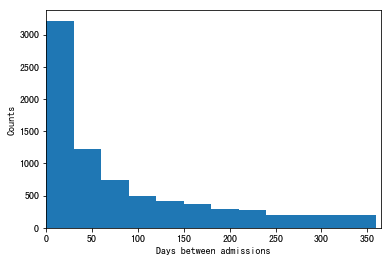

In [22]:
# plot a histogram of days between readmissions if they exist
# this only works for non-null values so you have to filter
plt.hist(df_adm.loc[~df_adm.DAYS_NEXT_ADMIT.isnull(),'DAYS_NEXT_ADMIT'], bins =range(0,365,30))
plt.xlim([0,365])
plt.xlabel('Days between admissions')
plt.ylabel('Counts')
plt.show()

In [23]:
print('Number with a readmission:', (~df_adm.DAYS_NEXT_ADMIT.isnull()).sum())
print('Total Number:', len(df_adm))

Number with a readmission: 11399
Total Number: 58976


## readmission < 30 Plot

In [26]:
df_nonad =  df_adm[df_adm.DAYS_NEXT_ADMIT.isnull()]
df_rad = df_adm[df_adm['DAYS_NEXT_ADMIT'] < 30]
df_lrad = df_adm[df_adm['DAYS_NEXT_ADMIT'] >= 30]

If the value count of the specific type is less than 10% of the total count of the 

In [74]:
def plot_ca(name):
    
    fig,ax1 = plt.subplots(figsize=(12,5),dpi=80)
    df1 = df_nonad[name].value_counts().to_frame(name='nonad')
    df2 = df_rad[name].value_counts().to_frame(name='ad')
    df = df1.merge(df2, how='left', left_index=True, right_index=True).fillna(0)
    df['y'] = df['ad'] / df['nonad']
    name_list = list(df.index)
    X = range(len(df))
    plt.bar(X, df['nonad'], alpha=0.9, width = 0.55, facecolor = 'lightskyblue', 
            edgecolor = 'white', lw=1, tick_label=name_list, label='non-readmitted')
    plt.bar(X, df['ad'], bottom=df['nonad'], alpha=0.9, width = 0.55, color = 'r', 
            edgecolor = 'white', lw=1, label='readmitted in 30 Days')
    plt.xticks(rotation=70, fontsize=16)

    # ax.set_xlabel(name, color='k', fontsize=14)
    ax1.set_title(name, fontsize=14)
    plt.legend(loc = 'best')

    # add number
#     for x,y in enumerate(list(nonad)):
#         ax.text(x - 0.15, y + 500,y,va='center',fontsize=14)

    y = list(df['y'])
    axes2 = ax1.twinx()
    axes2.plot(X, y, color='k', marker='d', label='non-readmitted / readmitted in 30 days')
    axes2.set_ylim(0, 1)
    axes2.set_ylabel('Line Plot')
    for i,v in enumerate(y):
        axes2.text(i - 0.15, v + 0.05,round(v,4),va='center',fontsize=14)
    
    plt.legend(loc = 7)
    plt.show()

In [75]:
df_adm.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'NEXT_ADMITTIME',
       'NEXT_ADMISSION_TYPE', 'DAYS_NEXT_ADMIT'],
      dtype='object')

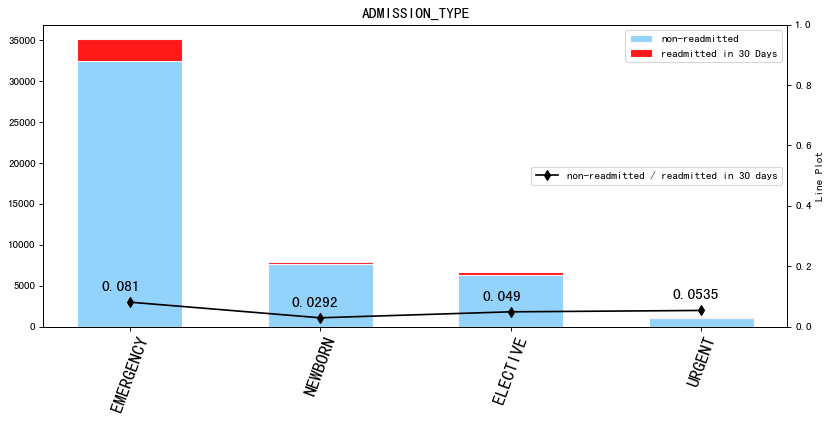

In [85]:
plot_ca('ADMISSION_TYPE')

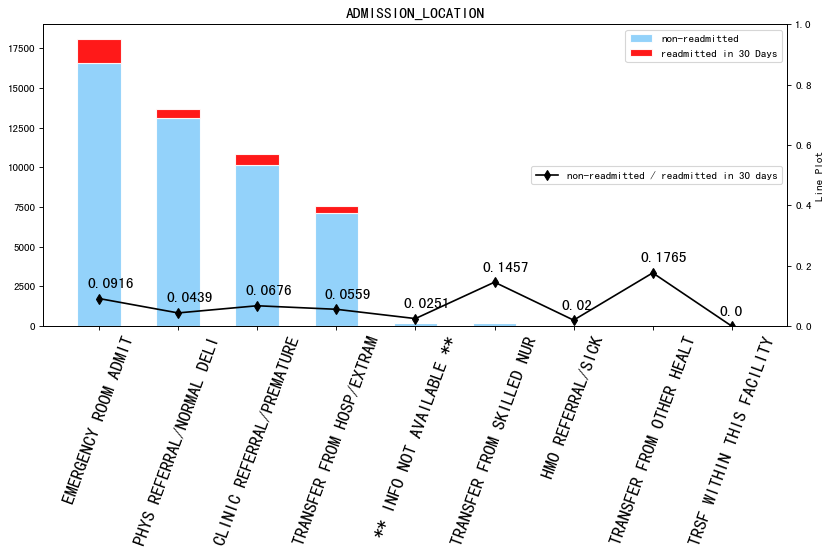

In [86]:
plot_ca('ADMISSION_LOCATION')

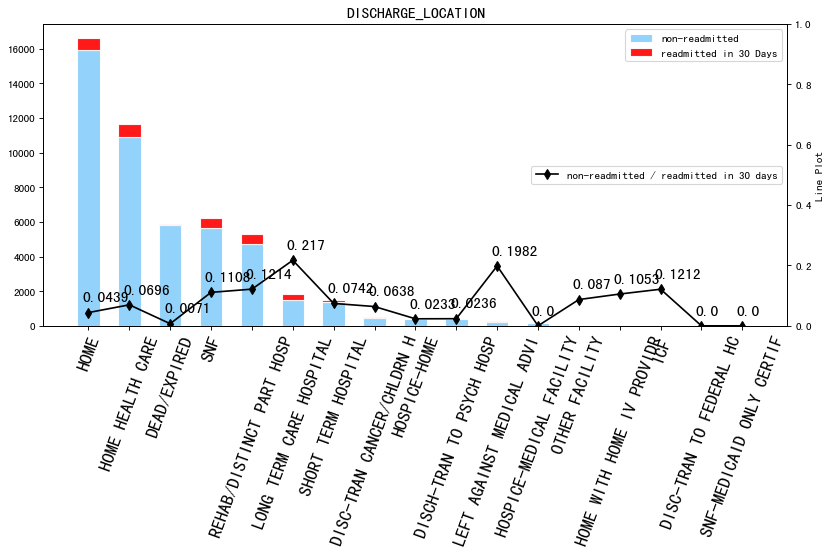

In [78]:
plot_ca('DISCHARGE_LOCATION')

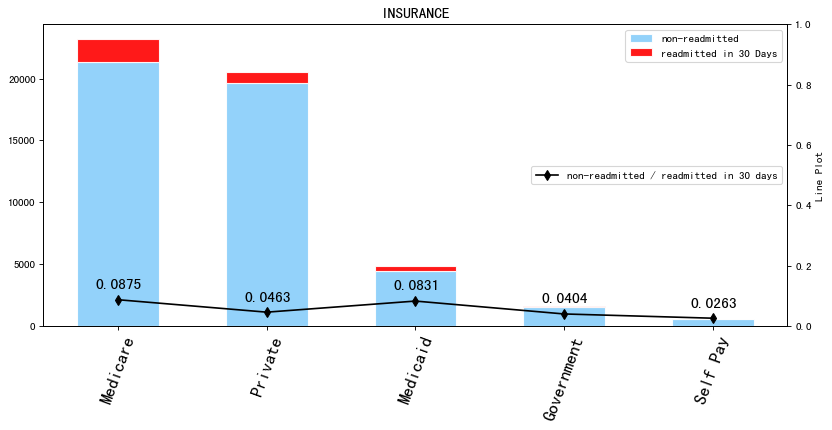

In [79]:
plot_ca('INSURANCE')

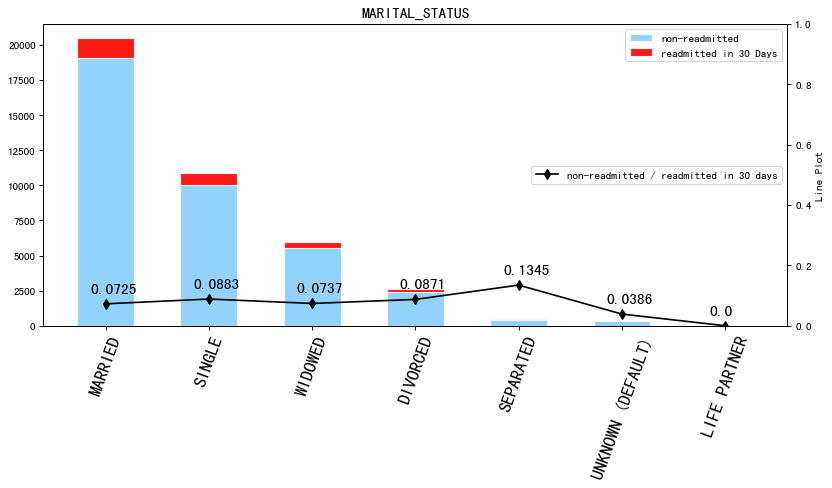

In [81]:
plot_ca('MARITAL_STATUS')

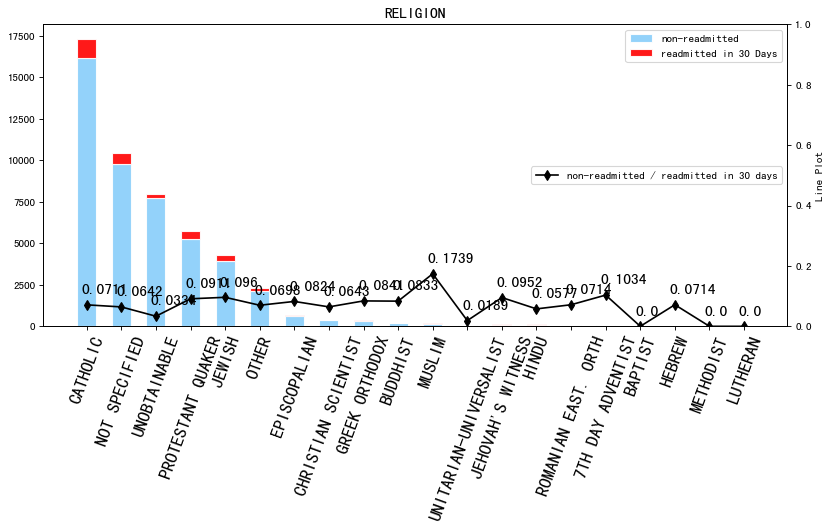

In [82]:
plot_ca('RELIGION')

From the previous plot, we can know that readmitted patients and non-readmitted patients are really same. There are no obvious realation between the data and whether patients will be readmitted.

## Load the notes

In [23]:
df_notes = pd.read_csv(path + 'NOTEEVENTS.csv', header=0, sep=',', quotechar='"')

/Users/yizhuoli/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [24]:
df_notes.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [25]:
print('Number of notes:',len(df_notes))

Number of notes: 2083180


There can be multiple notes per hospitalizations so don't worry that the number of notes is higher than the number of hospitalizations. 

In [26]:
df_notes.CATEGORY.unique()

array(['Discharge summary', 'Echo', 'ECG', 'Nursing', 'Physician ',
       'Rehab Services', 'Case Management ', 'Respiratory ', 'Nutrition',
       'General', 'Social Work', 'Pharmacy', 'Consult', 'Radiology',
       'Nursing/other'], dtype=object)

In [27]:
# look at the first note
df_notes.TEXT.iloc[0]

'Admission Date:  [**2151-7-16**]       Discharge Date:  [**2151-8-4**]\n\n\nService:\nADDENDUM:\n\nRADIOLOGIC STUDIES:  Radiologic studies also included a chest\nCT, which confirmed cavitary lesions in the left lung apex\nconsistent with infectious process/tuberculosis.  This also\nmoderate-sized left pleural effusion.\n\nHEAD CT:  Head CT showed no intracranial hemorrhage or mass\neffect, but old infarction consistent with past medical\nhistory.\n\nABDOMINAL CT:  Abdominal CT showed lesions of\nT10 and sacrum most likely secondary to osteoporosis. These can\nbe followed by repeat imaging as an outpatient.\n\n\n\n                            [**First Name8 (NamePattern2) **] [**First Name4 (NamePattern1) 1775**] [**Last Name (NamePattern1) **], M.D.  [**MD Number(1) 1776**]\n\nDictated By:[**Hospital 1807**]\nMEDQUIST36\n\nD:  [**2151-8-5**]  12:11\nT:  [**2151-8-5**]  12:21\nJOB#:  [**Job Number 1808**]\n'

We can see that the dates and PHI have been converted for confidentiality. There are '\n' characters, numbers and punctuation. 

At this point, we have to make a choice on what notes to use. For simplicity, let's use the discharge summary, but we could use all the notes by concatenating them. 

In [28]:
# filter to discharge summary
df_notes_dis_sum = df_notes.loc[df_notes.CATEGORY == 'Discharge summary']

In [29]:
assert df_notes_dis_sum.duplicated(['HADM_ID']).sum() == 0, 'Multiple discharge summaries per admission'

AssertionError: Multiple discharge summaries per admission

In [30]:
df_notes_dis_sum_last = (df_notes_dis_sum.groupby(['SUBJECT_ID','HADM_ID']).nth(-1)).reset_index()
assert df_notes_dis_sum_last.duplicated(['HADM_ID']).sum() == 0, 'Multiple discharge summaries per admission'

## Merge data sets

In [31]:
df_adm_notes = pd.merge(df_adm[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','DAYS_NEXT_ADMIT','NEXT_ADMITTIME','ADMISSION_TYPE','DEATHTIME']],
                        df_notes_dis_sum_last[['SUBJECT_ID','HADM_ID','TEXT']], 
                        on = ['SUBJECT_ID','HADM_ID'],
                        how = 'left')
assert len(df_adm) == len(df_adm_notes), 'Number of rows increased'

Check to see if there are alot of notes that are missing text (might be a sign of a problem).

In [32]:
print('Fraction of missing notes:', df_adm_notes.TEXT.isnull().sum() / len(df_adm_notes))
print('Fraction notes with newlines:', df_adm_notes.TEXT.str.contains('\n').sum() / len(df_adm_notes))
print('Fraction notes with carriage returns:', df_adm_notes.TEXT.str.contains('\r').sum() / len(df_adm_notes))

Fraction of missing notes: 0.1059753119913185
Fraction notes with newlines: 0.8940246880086815
Fraction notes with carriage returns: 0.0


In [33]:
df_adm_notes.groupby('ADMISSION_TYPE').apply(lambda g: g.TEXT.isnull().sum())/df_adm_notes.groupby('ADMISSION_TYPE').size()

ADMISSION_TYPE
ELECTIVE     0.048663
EMERGENCY    0.037983
NEWBORN      0.536691
URGENT       0.042665
dtype: float64

Remove NEWBORN

In [34]:
df_adm_notes_clean = df_adm_notes.loc[df_adm_notes.ADMISSION_TYPE != 'NEWBORN'].copy()

In [35]:
print('Fraction of missing notes:', df_adm_notes_clean.TEXT.isnull().sum() / len(df_adm_notes_clean))
print('Fraction notes with newlines:', df_adm_notes_clean.TEXT.str.contains('\n').sum() / len(df_adm_notes_clean))
print('Fraction notes with carriage returns:', df_adm_notes_clean.TEXT.str.contains('\r').sum() / len(df_adm_notes_clean))

Fraction of missing notes: 0.03971592354195606
Fraction notes with newlines: 0.9602840764580439
Fraction notes with carriage returns: 0.0


Additional analysis might be required to see if there are any specific cases why a discharge would not appear. For now, we will push forward. 

## Prepare a label

I like to create a specific column in the dataframe as OUTPUT_LABEL that has exactly what we are trying to predict. Here we want if the patient was re-admitted within 30 days

In [36]:
df_adm_notes_clean['OUTPUT_LABEL'] = (df_adm_notes_clean.DAYS_NEXT_ADMIT < 30).astype('int')

In [37]:
print('Number of positive samples:', (df_adm_notes_clean.OUTPUT_LABEL == 1).sum())
print('Number of negative samples:',  (df_adm_notes_clean.OUTPUT_LABEL == 0).sum())
print('Total samples:', len(df_adm_notes_clean))

Number of positive samples: 3004
Number of negative samples: 48109
Total samples: 51113


# Create training and test dataframes

When we build a predictive model, we want the model to work well on data that the model has never seen. To test for this, we take our data and split it into three datasets: training, validation and test. 

- training set: used to train the model
- validation set: data the model didn't see, but are used to optimize or tune the model
- test set: data the model and tuning process never saw (true test of generalizability)

The validation and test set should be as close to the production data as possible. We don't want to make decisions on validation data that is not from same type of data as the test set. For example, don't use high resolution images for validation set if you think production will be amateur photos from your phone. 


In [38]:
# shuffle the samples
df_adm_notes_clean = df_adm_notes_clean.sample(n = len(df_adm_notes_clean), random_state = 42)
df_adm_notes_clean = df_adm_notes_clean.reset_index(drop = True)

# Save 30% of the data as validation and test data 
df_valid_test=df_adm_notes_clean.sample(frac=0.30,random_state=42)

df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)

# use the rest of the data as training data
df_train_all=df_adm_notes_clean.drop(df_valid_test.index)

print('Test prevalence(n = %d):'%len(df_test),df_test.OUTPUT_LABEL.sum()/ len(df_test))
print('Valid prevalence(n = %d):'%len(df_valid),df_valid.OUTPUT_LABEL.sum()/ len(df_valid))
print('Train all prevalence(n = %d):'%len(df_train_all), df_train_all.OUTPUT_LABEL.sum()/ len(df_train_all))
print('all samples (n = %d)'%len(df_adm_notes_clean))
assert len(df_adm_notes_clean) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'

Test prevalence(n = 7667): 0.061953828094430674
Valid prevalence(n = 7667): 0.056997521846876224
Train all prevalence(n = 35779): 0.05847005226529529
all samples (n = 51113)


Since the prevalence is so low, we want to prevent the model from always predicting negative. To do this, we have a few options
- balance the data by sub-sampling the negatives
- balance the data by over-sampling the positives
- create synthetic data (e.g. SMOTE)

In this example, we will sub-sample the negatives

In [39]:
# split the training data into positive and negative
rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples 
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

print('Train prevalence (n = %d):'%len(df_train), df_train.OUTPUT_LABEL.sum()/ len(df_train))

Train prevalence (n = 4184): 0.5


# Step 2: Preprocess text data

Now that we have created data sets that have a label and the notes, we need to preprocess our text data to convert it to something useful (i.e. numbers) for the machine learning model. We are going to use the Bag-of-Words (BOW) approach.

BOW basically breaks up the note into the individual words and counts how many times each word occurs. Your numerical data then becomes counts for some set of words as shown below. BOW is the simplest way to do NLP classification. In most blog posts I have read, fancier techniques have a hard time beating BOW for NLP classification tasks.

In this process, there are few choices that need to be made
- how to pre-process the words
- how to count the words
- which words to use

There is no optimal choice for all NLP projects, so I recommend trying out a few options when building your own models.

You can do the pre-processing in two ways:
- modify the original dataframe TEXT column
- pre-process as part of your pipeline so you don't edit the original data (allows you try out a few options easily)

### Preprocess all the notes

Modify the original dataframe by dealing with the missing text, newlines and carriage returns

In [40]:
def preprocess_text(df):
    # This function preprocesses the text by filling not a number and replacing new lines ('\n') and carriage returns ('\r')
    df.TEXT = df.TEXT.fillna(' ')
    df.TEXT =df.TEXT.str.replace('\n',' ')
    df.TEXT =df.TEXT.str.replace('\r',' ')
    return df

In [41]:
# preprocess the text to deal with known issues
df_train = preprocess_text(df_train)
df_valid = preprocess_text(df_valid)
df_test = preprocess_text(df_test)

### Build a tokenizer

Now we need to create a function that splits the note into individual words. This function is called a tokenizer. We can use the nltk.word_tokenize function to this for us. 

In [42]:
import nltk
from nltk import word_tokenize
word_tokenize('This should be tokenized. 02/02/2018 sentence has stars**')

['This',
 'should',
 'be',
 'tokenized',
 '.',
 '02/02/2018',
 'sentence',
 'has',
 'stars**']

Note that some punctuation is separated but not all punctuation. 

We can define our own custom tokenizer. Our tokenizer will 
- replace punctuation with spaces
- remove numbers with spaces
- lowercase all words

I like to do these steps as part of the tokenizer, so I can go back and look at the original note. The new line and carriage return is more difficult to deal with so I did it in the preprocessing step above. 

In [43]:
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [44]:
def tokenizer_better(text):
    # tokenize the text by replacing punctuation and numbers with spaces and lowercase all words
    
    punc_list = string.punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.lower().translate(t)
    tokens = word_tokenize(text)
    return tokens

In [45]:
tokenizer_better('This should be tokenized. 02/02/2018 sentence has stars**')

['this', 'should', 'be', 'tokenized', 'sentence', 'has', 'stars']

### Build a simple vectorizer

Now that we have a way to convert free-text into tokens, we need a way to create features from these tokens. 

In [46]:
sample_text = ['Data science is about the data', 'The science is amazing', 'Predictive modeling is part of data science']

In [47]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(tokenizer = tokenizer_better)
vect.fit(sample_text)

# matrix is stored as a sparse matrix (since you have a lot of zeros)
X = vect.transform(sample_text)

In [48]:
X

<3x10 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>

In [49]:
# we can visualize this small example if we convert it to an array
X.toarray()

array([[1, 0, 2, 1, 0, 0, 0, 0, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 0, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0]])

In [50]:
# get the column names
vect.get_feature_names()

['about',
 'amazing',
 'data',
 'is',
 'modeling',
 'of',
 'part',
 'predictive',
 'science',
 'the']

## build a vectorizer on the clinical notes

In [51]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features = 3000, tokenizer = tokenizer_better)

# this could take a while
vect.fit(df_train.TEXT.values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=3000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenizer_better at 0x13272a7b8>,
        vocabulary=None)

# Zipf's law

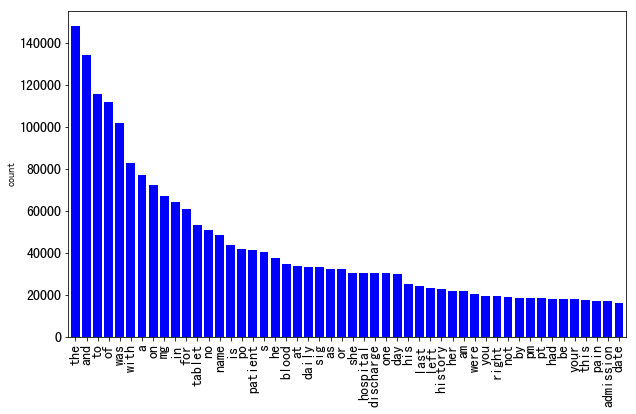

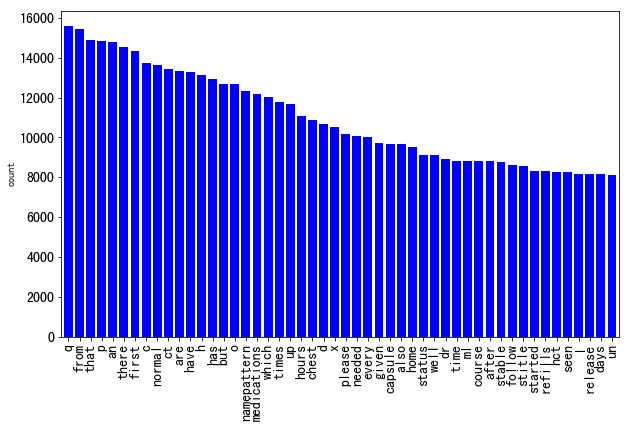

In [52]:
neg_doc_matrix = vect.transform(df_train[df_train.OUTPUT_LABEL == 0].TEXT)
pos_doc_matrix = vect.transform(df_train[df_train.OUTPUT_LABEL == 1].TEXT)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

term_freq_df = pd.DataFrame([neg,pos],columns=vect.get_feature_names()).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

#Create a series from the sparse matrix
d = pd.Series(term_freq_df.total, 
              index = term_freq_df.index).sort_values(ascending=False)
ax = d[:50].plot(kind='bar', figsize=(10,6), width=.8, fontsize=14, rot=90,color = 'b')
ax.title.set_size(18)
plt.ylabel('count')
plt.show()
ax = d[50:100].plot(kind='bar', figsize=(10,6), width=.8, fontsize=14, rot=90,color = 'b')
ax.title.set_size(18)
plt.ylabel('count')
plt.show()

In [53]:
my_stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
                 'is','patient','s','he','at','as','or','one','she','his','her','am',
                 'were','you','pt','pm','by','be','had','your','this','date',
                'from','there','an','that','p','are','have','has','h','but','o',
                'namepattern','which','every','also']

In [54]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features = 3000, 
                       tokenizer = tokenizer_better, 
                       stop_words = my_stop_words)
# this could take a while
vect.fit(df_train.TEXT.values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=3000, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['the', 'and', 'to', 'of', 'was', 'with', 'a', 'on', 'in', 'for', 'name', 'is', 'patient', 's', 'he', 'at', 'as', 'or', 'one', 'she', 'his', 'her', 'am', 'were', 'you', 'pt', 'pm', 'by', 'be', 'had', 'your', 'this', 'date', 'from', 'there', 'an', 'that', 'p', 'are', 'have', 'has', 'h', 'but', 'o', 'namepattern', 'which', 'every', 'also'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenizer_better at 0x13272a7b8>,
        vocabulary=None)

In [61]:
import pickle
# now pickle
pickle.dump(vect, open("vector.pickel", "wb"))

Transform notes into the vector format

In [55]:
X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)

Get labels


In [56]:
y_train = df_train.OUTPUT_LABEL
y_valid = df_valid.OUTPUT_LABEL

In [58]:
X_test_tf = vect.transform(df_test.TEXT.values)
y_test = df_test.OUTPUT_LABEL

In [62]:
save_path = "cleaned_data/"
df_train.to_csv(save_path + "df_train.csv")
df_valid.to_csv(save_path + "df_valid.csv")
df_test.to_csv(save_path + "df_test.csv")